# Data preparation

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle competitions download -c python-and-analyze-data-final-project

transactions.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
gender_test_kaggle_sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
tr_types.csv: Skipping, found more recently modified local copy (use --force to force download)
tr_mcc_codes.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import catboost
import optuna

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from tqdm.notebook import tqdm_notebook
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('max_columns', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)
pd.set_option('max_colwidth', 300)

In [ ]:
tr_mcc_codes = pd.read_csv('/content/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('/content/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('/content/transactions.csv.zip', index_col='customer_id')
gender_train = pd.read_csv('/content/gender_train.csv', index_col='customer_id')
gender_test = pd.read_csv('/content/gender_test_kaggle_sample_submission.csv', index_col='customer_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

In [ ]:
for df in [transactions_train, transactions_test]:
    df['day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)

In [ ]:
tqdm_notebook.pandas(desc="Progress:")

def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('negative_transactions_')))

    features.append(pd.Series(x['mcc_code'].value_counts(normalize=True).add_prefix('mcc_')))
    features.append(pd.Series(x['tr_type'].value_counts(normalize=True).add_prefix('tr_type_')))
    
    return pd.concat(features)


In [ ]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(features_creation_advanced).unstack(-1)

target = data_train.join(gender_train, how='inner')['gender']
test_target = data_test.join(gender_test, how='inner')['probability']
target.value_counts()

Progress::   0%|          | 0/8400 [00:00<?, ?it/s]

Progress::   0%|          | 0/3600 [00:00<?, ?it/s]

0    4687
1    3713
Name: gender, dtype: int64

It is clear that classes are somewhat balanced

In [ ]:
data_test

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_2,hour_20,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,mcc_1711,mcc_1731,mcc_1799,mcc_2741,mcc_3000,mcc_3351,mcc_3501,mcc_4111,mcc_4112,mcc_4121,mcc_4131,mcc_4214,mcc_4215,mcc_4411,mcc_4511,mcc_4722,mcc_4784,mcc_4789,mcc_4812,...,tr_type_2371,tr_type_2440,tr_type_2446,tr_type_2456,tr_type_2460,tr_type_4010,tr_type_4011,tr_type_4020,tr_type_4021,tr_type_4031,tr_type_4041,tr_type_4045,tr_type_4051,tr_type_4061,tr_type_4071,tr_type_4090,tr_type_4096,tr_type_4097,tr_type_4100,tr_type_4110,tr_type_4200,tr_type_4210,tr_type_4500,tr_type_6000,tr_type_6010,tr_type_6100,tr_type_6110,tr_type_6200,tr_type_6210,tr_type_7010,tr_type_7011,tr_type_7014,tr_type_7015,tr_type_7020,tr_type_7021,tr_type_7024,tr_type_7025,tr_type_7030,tr_type_7031,tr_type_7034,tr_type_7035,tr_type_7040,tr_type_7041,tr_type_7044,tr_type_7070,tr_type_7071,tr_type_7074,tr_type_7075,tr_type_8100,tr_type_8146
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6815,0.119469,0.132743,0.119469,0.163717,0.181416,0.146018,0.137168,NaN,0.004425,0.181416,0.132743,0.061947,0.079646,0.159292,0.079646,0.039823,0.039823,0.030973,0.026549,0.004425,0.030973,0.008850,NaN,NaN,NaN,NaN,NaN,0.004425,0.008850,0.017699,0.088496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27914,0.135135,0.261261,0.180180,0.090090,0.135135,0.027027,0.171171,0.018018,NaN,0.126126,0.090090,0.027027,0.081081,0.126126,0.018018,0.117117,0.054054,0.027027,0.018018,NaN,NaN,NaN,NaN,NaN,0.009009,0.009009,0.018018,0.018018,0.054054,0.144144,0.045045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.297297,NaN,NaN,NaN,0.018018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31385,0.153425,0.120548,0.145205,0.123288,0.145205,0.167123,0.145205,0.030137,NaN,0.060274,0.106849,0.052055,0.098630,0.038356,0.043836,0.052055,0.043836,0.063014,0.049315,NaN,0.049315,0.109589,0.071233,0.008219,NaN,NaN,NaN,NaN,0.043836,0.043836,0.035616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002740,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00274,NaN,NaN,0.005479,0.005479,NaN,0.002740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021918,NaN,NaN,0.013699,0.005479,NaN,NaN,NaN,0.010959,NaN,NaN,0.005479,0.002740,NaN,NaN,NaN,NaN,NaN,0.002740,NaN,NaN,NaN,NaN,NaN
38084,0.142857,0.153361,0.110294,0.130252,0.159664,0.137605,0.165966,0.143908,0.006303,0.053571,0.054622,0.055672,0.073529,0.059874,0.047269,0.118697,0.096639,0.046218,0.044118,0.004202,0.039916,0.013655,0.015756,0.008403,0.004202,0.002101,0.005252,0.008403,0.007353,0.028361,0.061975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003151,NaN,NaN,NaN,NaN,NaN,NaN,0.001050,NaN,NaN,0.005252,...,0.004202,NaN,NaN,NaN,NaN,0.007353,0.00105,NaN,NaN,NaN,NaN,NaN,0.002101,NaN,0.004202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.087185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014706,NaN,NaN,NaN,NaN,NaN,NaN,0.017857,NaN,NaN,NaN,NaN,NaN
78659,0.159875,0.119122,0.134796,0.147335,0.134796,0.147335,0.156740,0.291536,NaN,0.009404,0.018809,0.021944,0.012539,0.047022,0.043887,0.021944,0.040752,0.025078,0.040752,NaN,0.141066,0.137931,0.062696,0.025078,0.009404,0.034483,0.003135,NaN,NaN,0.003135,0.009404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003135,NaN,0.097179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04

In [ ]:
target = data_train.join(gender_train, how='inner')['gender']
test_target = data_test.join(gender_test, how='inner')['probability']
test_target = test_target.to_frame()

#some of the features are not present in test and train sets so let's delete them
test_features = data_test.columns.to_list()
train_features = data_train.columns.to_list()

data_test = data_test.drop([x for x in test_features if x not in train_features], axis=1)
data_train = data_train.drop([x for x in train_features if x not in test_features], axis=1)

In [ ]:
X = data_train.copy()
y = target
test_df = data_test.copy()

X.fillna(-1, inplace=True)
test_df.fillna(-1, inplace=True)
scaler = StandardScaler()
X = scaler.fit_transform(X)
test_df = scaler.fit_transform(test_df)

X.shape, test_df.shape

((8400, 304), (3600, 304))

# Model

In [ ]:
model = catboost.CatBoostClassifier(n_estimators=300)
model.fit(X,y)

Learning rate set to 0.077105
0:	learn: 0.6708862	total: 85ms	remaining: 25.4s
1:	learn: 0.6514069	total: 153ms	remaining: 22.8s
2:	learn: 0.6372674	total: 220ms	remaining: 21.8s
3:	learn: 0.6210645	total: 283ms	remaining: 20.9s
4:	learn: 0.6084875	total: 348ms	remaining: 20.5s
5:	learn: 0.5954136	total: 414ms	remaining: 20.3s
6:	learn: 0.5845983	total: 481ms	remaining: 20.1s
7:	learn: 0.5744677	total: 548ms	remaining: 20s
8:	learn: 0.5654904	total: 617ms	remaining: 20s
9:	learn: 0.5592246	total: 683ms	remaining: 19.8s
10:	learn: 0.5515547	total: 755ms	remaining: 19.8s
11:	learn: 0.5446227	total: 823ms	remaining: 19.8s
12:	learn: 0.5387081	total: 893ms	remaining: 19.7s
13:	learn: 0.5338950	total: 957ms	remaining: 19.6s
14:	learn: 0.5294960	total: 1.04s	remaining: 19.7s
15:	learn: 0.5257418	total: 1.11s	remaining: 19.6s
16:	learn: 0.5210425	total: 1.17s	remaining: 19.5s
17:	learn: 0.5175217	total: 1.23s	remaining: 19.3s
18:	learn: 0.5142404	total: 1.3s	remaining: 19.2s
19:	learn: 0.5107

In [ ]:
feat_imp = {
    'feature': data_train.columns,
    'feature_importance': model.get_feature_importance()
}

fimp = model.get_feature_importance()

df_feat_imp = pd.DataFrame(feat_imp)
df_feat_imp

In [ ]:
#some of the features have zero feature importance

df_feat_imp = df_feat_imp.sort_values('feature_importance', ascending=False)
df_feat_imp = df_feat_imp[df_feat_imp['feature_importance']>0]

In [ ]:
df_feat_imp.head()

,feature,feature_importance
146,mcc_5977,6.162479
94,mcc_5533,5.172112
95,mcc_5541,4.285753
105,mcc_5661,3.231115
124,mcc_5912,3.150768


It appears that Cosmetics (5977), Car accessories (5533), Car services (5541), Shoe stores (5661) and Pharmacies (5912) are the most significant categories.

In [ ]:
#ket's see how the model will perform without zero-like feature_importance

data_train_upd = data_train[df_feat_imp.feature.iloc[:181].to_list()]
data_test_upd = data_test[df_feat_imp.feature.iloc[:181].to_list()]

X_upd = data_train_upd.copy()
y = target
test_df_upd = data_test_upd.copy()

X_upd.fillna(-1, inplace=True)
test_df_upd.fillna(-1, inplace=True)
scaler = StandardScaler()
X_upd = scaler.fit_transform(X_upd)
test_df_upd = scaler.fit_transform(test_df_upd)

X_upd.shape, test_df_upd.shape

((8400, 181), (3600, 181))

In [ ]:
model = catboost.CatBoostClassifier(n_estimators=400)
model.fit(X_upd, y)

In [ ]:
test_target = test_target.round(0).astype(int)

Let's finetune the model with optuna

In [ ]:
def objective(trial):
  param = {
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }
  if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
  elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

  mod = catboost.CatBoostClassifier(**param)

  mod.fit(X_upd,y)

  preds = mod.predict(test_df_upd)
  pred_labels = np.rint(preds)
  scor = roc_auc_score(test_target, pred_labels)
  return scor

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


In [ ]:
model_optuned = catboost.CatBoostClassifier(colsample_bylevel=0.030140661107958613, depth=10, boosting_type='Ordered', bootstrap_type='Bayesian', bagging_temperature=2.621899464840254)
model_optuned.fit(X_upd, y)

In [ ]:
y_train_predicted = model_optuned.predict_proba(X_upd)[:,-1]
y_test_predicted = model_optuned.predict_proba(test_df_upd)[:,-1]

I got score of 0.85024 on Kaggle: 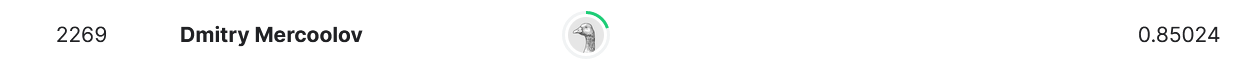

In [ ]:
submission = pd.DataFrame(index=data_test.index)
submission['probability'] = y_test_predicted
submission.to_csv('submission_catboost_optuned_3.csv')
submission

,probability
customer_id,
6815,0.324550
27914,0.653456
31385,0.017056
38084,0.003934
78659,0.599998
...,...
99918216,0.357100
99938948,0.003945
99953525,0.109387


In [ ]:
from google.colab import files

files.download('submission_catboost_optuned_3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>